In [1]:
from fastai.vision import *

In [2]:
import warnings
warnings.filterwarnings('ignore')

## Goal
Build a CNN that can classify musical instruments

## Instruments
### Strings
Violin, Viola, Cello, Bass (double bass, not bass guitar), Guitar

### Woodwinds
Flute, Oboe, Clarinet, Bassoon, Saxophone

### Brass
Trumpet, French horn, Trombone, Euphonium, Tuba

### Keyboards
Piano, Keyboard / synth, Harp

### Percussion
Drums (timpani, snare, bass, etc), Cymbals, Tambourine, Gong, Triangle, Xylophone

## Fetching Data
Using a Google Image search and the following script to fetch pictures. Up to 200 pictures per instrument.
```javascript
urls=Array.from(document.querySelectorAll('.rg_i')).map(el=> el.hasAttribute('data-src')?el.getAttribute('data-src'):el.getAttribute('data-iurl')).filter(el => el != null).slice(0,200);
window.open('data:text/csv;charset=utf-8,' + escape(urls.join('\n')));
```

In [3]:
classes = ['violin', 'viola', 'cello', 'doublebass', 'guitar', 'flute', 'oboe', 'clarinet', 'bassoon', 'saxophone', 'trumpet', 'frenchhorn', 'trombone', 'euphonium', 'tuba', 'piano', 'keyboard', 'harp', 'drums', 'cymbals', 'tambourine', 'gong', 'triangle', 'xylophone']

In [4]:
# Create the subfolders to hold training data
path = Path('data/instruments')
for c in classes:
    dest = path/c
    dest.mkdir(parents=True, exist_ok=True)

In [13]:
#!mv ./data/instruments/*.jpg ./data/instruments/violin

In [16]:
# Download the data 1 class at a time instead of in a loop so we can respond to any errors as we go
c = classes[1]
url_path = Path('data/urls/urls_%s.txt' % c)
img_path = Path('data/instruments/%s' % c)
download_images(url_path, img_path,  max_pics=200)

In [ ]:
# Download quickly in a loop
for c in classes:
    print(c)
    url_path = Path('data/urls/urls_%s.txt' % c)
    img_path = Path('data/instruments/%s' % c)
    download_images(url_path, img_path,  max_pics=200)

In [ ]:
# Validate the files
for c in classes:
    print(c)
    img_path = Path('data/instruments/%s' % c)
    verify_images(img_path, delete=True, max_size=500)

In [36]:
# make a zip so we can download our images
import shutil
shutil.make_archive('instruments', 'zip', path)

'/data/home/celetra/notebooks/fastai/course-v3/nbs/dl1/instruments.zip.zip'

In [6]:
np.random.seed(42)
path = Path('data/instruments')
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.2,
        ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

In [7]:
data.classes

['bassoon',
 'cello',
 'clarinet',
 'cymbals',
 'doublebass',
 'drums',
 'euphonium',
 'flute',
 'frenchhorn',
 'gong',
 'guitar',
 'harp',
 'keyboard',
 'oboe',
 'piano',
 'saxophone',
 'tambourine',
 'triangle',
 'trombone',
 'trumpet',
 'tuba',
 'viola',
 'violin',
 'xylophone']

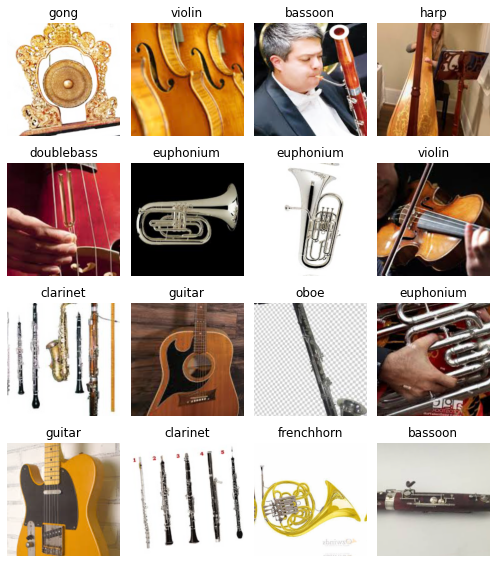

In [8]:
data.show_batch(rows=4, figsize=(7,8))

In [9]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['bassoon',
  'cello',
  'clarinet',
  'cymbals',
  'doublebass',
  'drums',
  'euphonium',
  'flute',
  'frenchhorn',
  'gong',
  'guitar',
  'harp',
  'keyboard',
  'oboe',
  'piano',
  'saxophone',
  'tambourine',
  'triangle',
  'trombone',
  'trumpet',
  'tuba',
  'viola',
  'violin',
  'xylophone'],
 24,
 3808,
 952)

# Train the model

In [10]:
learn = cnn_learner(data, models.resnet50, metrics=error_rate)

In [11]:
# Train 4 epochs
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.731331,0.985782,0.299370,01:11
1,1.188950,0.841007,0.257353,01:01
2,0.858471,0.711890,0.240546,01:01
3,0.641396,0.680557,0.228992,01:01


In [12]:
learn.save('stage-1')

In [13]:
learn.unfreeze()

In [14]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


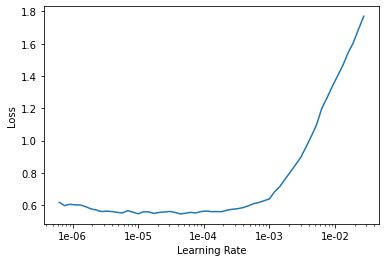

In [15]:
learn.recorder.plot()

In [16]:
learn.fit_one_cycle(2, max_lr=slice(1e-5,1e-3))

epoch,train_loss,valid_loss,error_rate,time
0,0.626378,0.730590,0.236345,01:21
1,0.526351,0.679914,0.230042,01:21


In [17]:
learn.save('stage-2')

In [18]:
interp = ClassificationInterpretation.from_learner(learn)

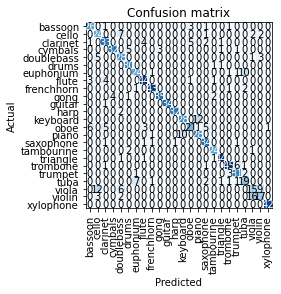

In [19]:
interp.plot_confusion_matrix()

# Data cleaning

In [20]:
from fastai.widgets import *

In [21]:
'''
db = (ImageList.from_folder(path)
                   .split_none()
                   .label_from_folder()
                   .transform(get_transforms(), size=224)
                   .databunch()
     )
'''

In [33]:
# If you already cleaned your data using indexes from `from_toplosses`,
# run this cell instead of the one before to proceed with removing duplicates.
# Otherwise all the results of the previous step would be overwritten by
# the new run of `ImageCleaner`.

 db = (ImageList.from_csv(path, 'cleaned.csv', folder='.')
                    .split_none()
                    .label_from_df()
                    .transform(get_transforms(), size=224)
                    .databunch()
      )

In [34]:
learn_cln = cnn_learner(db, models.resnet50, metrics=error_rate)

learn_cln.load('stage-2');

In [31]:
ds, idxs = DatasetFormatter().from_toplosses(learn_cln)

In [32]:
# Don't run this in google colab or any other instances running jupyter lab.
# If you do run this on Jupyter Lab, you need to restart your runtime and
# runtime state including all local variables will be lost.
ImageCleaner(ds, idxs, path)

Button(button_style='primary', description='Next Batch', layout=Layout(width='auto'), style=ButtonStyle())

In [27]:
ds, idxs = DatasetFormatter().from_similars(learn_cln)

Getting activations...


Computing similarities...


In [28]:
ImageCleaner(ds, idxs, path, duplicates=True)

Button(button_style='primary', description='Next Batch', layout=Layout(width='auto'), style=ButtonStyle())

# Train with cleaned data

In [43]:
 db = (ImageList.from_csv(path, 'cleaned.csv', folder='.')
                    .split_by_rand_pct()
                    .label_from_df()
                    .transform(get_transforms(), size=224)
                    .databunch()
      )

In [51]:
learn_cln = cnn_learner(db, models.resnet50, metrics=error_rate)

learn_cln.load('stage-2')
learn_cln.unfreeze()

In [52]:
learn_cln.fit_one_cycle(5, max_lr=slice(5e-6,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.482615,0.266913,0.089827,01:19
1,0.457786,0.276590,0.090909,01:19
2,0.398205,0.284119,0.087662,01:20
3,0.336565,0.283954,0.096320,01:20
4,0.292777,0.277125,0.088745,01:20


In [53]:
learn_cln.save('stage-3');

In [55]:
learn_cln.load('stage-3')

Learner(data=ImageDataBunch;

Train: LabelList (3696 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
trombone,trombone,trombone,trombone,trombone
Path: data/instruments;

Valid: LabelList (924 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
clarinet,tuba,harp,guitar,doublebass
Path: data/instruments;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine

# Export model and get the environment

In [56]:
learn_cln.export()

In [ ]:
import sys
print(sys.executable)
!{sys.executable} -m pip list
!{sys.executable} --version

In [59]:
!ls -al ./data/instruments/*.pkl

-rw-rw-r-- 1 celetra celetra 102896027 Aug 14 09:47 ./data/instruments/export.pkl


In [60]:
!md5sum ./data/instruments/export.pkl

3757b33efb002ad60eeadeb53aad7fdb  ./data/instruments/export.pkl
